# IMPORTING LIBRARIES

In [1]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
import matplotlib.pyplot as plt
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve


# EDA

In [2]:
# LOADING THE DATASET
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding = 'Latin-1', names=('target','id','date','flag','username','tweet'))
df.head()

,target,id,date,flag,username,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
# Exploring the Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   target    1600000 non-null  int64 
 1   id        1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   flag      1600000 non-null  object
 4   username  1600000 non-null  object
 5   tweet     1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


<AxesSubplot:xlabel='target', ylabel='count'>

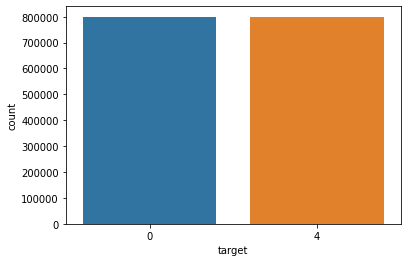

In [4]:
# countplot for the occurence of each target value
sns.countplot(x = 'target',data = df)

In [5]:
# dropped the irrelevant columns that will not be used in sentiment analysis
df.drop(['date','flag','username'], axis=1, inplace=True)
df.drop('id', axis=1, inplace=True)

In [6]:
df.head()

,target,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


# DATA PREPROCESSING

In [7]:
# FOR STOP WORDS
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# FOR LEMMATIZATION
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# FOR STEMMING
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# functionn for nlp pipeline
def data_preprocessing(raw_text):

    #Data Cleansing
    sentence = re.sub(r'[^\w\s]', ' ',raw_text )


    #Removing numbers
    sentence = re.sub(r'[0-9]', '', sentence)
    
    #Tokenization
    words = nltk.word_tokenize(sentence)

    #Lowercase
    for word in words:
            word.lower()
    
    #Stop words removal
    words = [w for w in words if not w in stop_words]
    
    #stemming
    words = [stemmer.stem(w) for w in words]
    
    #Lemmatization
    final_words = [lemmatizer.lemmatize(w) for w in words]
    
    return  final_words 

In [9]:
df.tweet = df.tweet.apply(data_preprocessing)

In [10]:
df.tweet

0          [switchfoot, http, twitpic, com, yzl, awww, bu...
1          [upset, updat, facebook, text, might, cri, res...
2          [kenichan, I, dive, mani, time, ball, manag, s...
3                     [whole, bodi, feel, itchi, like, fire]
4                      [nationwideclass, behav, mad, I, see]
                                 ...                        
1599995         [just, woke, have, school, best, feel, ever]
1599996    [thewdb, com, veri, cool, hear, old, walt, int...
1599997              [are, readi, mojo, makeov, ask, detail]
1599998    [happi, th, birthday, boo, alll, time, tupac, ...
1599999    [happi, charitytuesday, thenspcc, sparkschar, ...
Name: tweet, Length: 1600000, dtype: object

In [11]:
def listToString(s): 
    
    # initialize an empty string
    str1 = " " 
    
    # return string  
    return (str1.join(s))

string_list = []
for i in df.tweet :
    string = listToString(i)
    string_list.append(string)
    
# storing the string list created into the dataframe
df.tweet = string_list

In [12]:
df.tweet

0          switchfoot http twitpic com yzl awww bummer yo...
1          upset updat facebook text might cri result sch...
2          kenichan I dive mani time ball manag save the ...
3                            whole bodi feel itchi like fire
4                            nationwideclass behav mad I see
                                 ...                        
1599995                 just woke have school best feel ever
1599996    thewdb com veri cool hear old walt interview â...
1599997                     are readi mojo makeov ask detail
1599998    happi th birthday boo alll time tupac amaru sh...
1599999    happi charitytuesday thenspcc sparkschar speak...
Name: tweet, Length: 1600000, dtype: object

In [13]:
# converting the 4 in target column to 1 to denote the value 'positive'
df.target = df.target.apply(lambda x: 1 if x==4 else x)

In [14]:
X = df.tweet
y = df.target

In [15]:
# splitting the dataset into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=42)

In [16]:
# tranforming the tweet data into vectors matrix
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000, lowercase= False)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  500000


In [17]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

# IMPLOYING MODELS

### NAIVE BAYES MODEL

In [18]:
naive_model = ComplementNB().fit(X_train,y_train)

In [19]:
y_pred1 = naive_model.predict(X_test)
print(confusion_matrix(y_pred1,y_test))

[[187791  53967]
 [ 51570 186672]]


In [20]:
print(classification_report(y_pred1,y_test))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78    241758
           1       0.78      0.78      0.78    238242

    accuracy                           0.78    480000
   macro avg       0.78      0.78      0.78    480000
weighted avg       0.78      0.78      0.78    480000



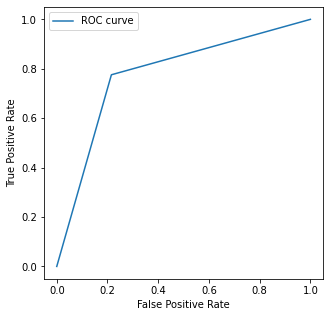

In [21]:
fpr_dt_1, tpr_dt_1,_ = roc_curve(y_test,y_pred1)
plt.plot(fpr_dt_1,tpr_dt_1,label = "ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.gcf().set_size_inches(5, 5)
plt.show()

### LOGISTIC REGRESSION

In [22]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(solver='liblinear').fit(X_train,y_train)
y_pred2= logistic.predict(X_test)
print(confusion_matrix(y_pred2,y_test))

[[186816  45423]
 [ 52545 195216]]


In [23]:
print(classification_report(y_pred2,y_test))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79    232239
           1       0.81      0.79      0.80    247761

    accuracy                           0.80    480000
   macro avg       0.80      0.80      0.80    480000
weighted avg       0.80      0.80      0.80    480000



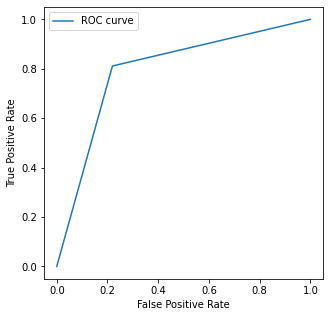

In [24]:
fpr_dt_1, tpr_dt_1,_ = roc_curve(y_test,y_pred2)
plt.plot(fpr_dt_1,tpr_dt_1,label = "ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.gcf().set_size_inches(5, 5)
plt.show()

### SVC MODEL

In [25]:
from sklearn.svm import LinearSVC
SVC = LinearSVC().fit(X_train,y_train)
y_pred3 = SVC.predict(X_test)
print(confusion_matrix(y_pred3,y_test))

[[184212  50020]
 [ 55149 190619]]


In [26]:
print(classification_report(y_pred3,y_test))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78    234232
           1       0.79      0.78      0.78    245768

    accuracy                           0.78    480000
   macro avg       0.78      0.78      0.78    480000
weighted avg       0.78      0.78      0.78    480000



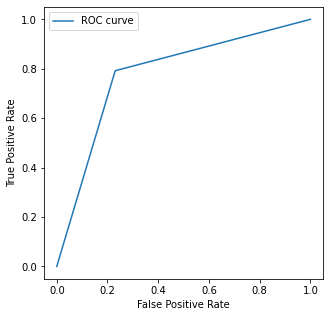

In [27]:
fpr_dt_1, tpr_dt_1,_ = roc_curve(y_test,y_pred3)
plt.plot(fpr_dt_1,tpr_dt_1,label = "ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.gcf().set_size_inches(5, 5)
plt.show()

### XGB CLASSIFIER

In [28]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred4 = model.predict(X_test)
print(confusion_matrix(y_pred4,y_test))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:43:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[160214  43629]
 [ 79147 197010]]


In [29]:
print(classification_report(y_pred4 ,y_test))

              precision    recall  f1-score   support

           0       0.67      0.79      0.72    203843
           1       0.82      0.71      0.76    276157

    accuracy                           0.74    480000
   macro avg       0.74      0.75      0.74    480000
weighted avg       0.76      0.74      0.75    480000



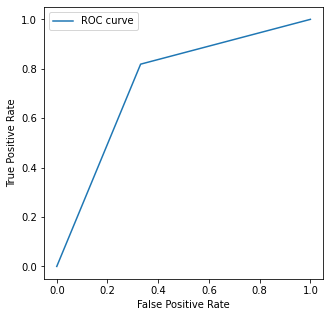

In [30]:
fpr_dt_1, tpr_dt_1,_ = roc_curve(y_test,y_pred4)
plt.plot(fpr_dt_1,tpr_dt_1,label = "ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.gcf().set_size_inches(5, 5)
plt.show()

As it can be observed that the Logistic Regression model is giving the best results.

In [37]:
# dataframe for test and predicted sentiments (from logistic regression model)
test = pd.DataFrame(list(zip((vectoriser.inverse_transform(X_test)) ,y_pred2, y_test)),
                    columns = ['TEST_TWEETS', 'PREDICTED' , 'ORIGINAL'])

In [39]:
test

,TEST_TWEETS,PREDICTED,ORIGINAL
0,"[your, hope your, hope, chrishasboob, ahhh hop...",1,0
1,"[tweet app, tweet, razr, misstoriblack, cool t...",1,0
2,"[whatev, time hang, time, sleepov, next time, ...",1,0
3,"[stupid school, stupid, stuff, school email, s...",0,0
4,"[upper, problem, airway]",0,0
...,...,...,...
479995,"[tivoli, stroller, mention also, mention, line...",1,1
479996,"[sun rain, sun, rain fuck, rain, miss sun, mis...",0,0
479997,"[time full, time, satisfi, mission, looooong t...",1,1
479998,"[wed, right enjoy, right, realli depress, real...",0,0
